In [1]:
import numpy as np
import pandas as pd
import requests, warnings

In [2]:
pd.set_option('display.max_rows', None)

In [15]:
reference_start = '2014-01-01'
outage_start = '2023-01-01'

In [16]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [17]:
ship_tracking_query = f'''
select destination_country_name, destination_location_name, closest_ancestor_grade, sum(cast(cargo_origin_barrels_split_by_product as bigint)) bbls from oil.dbo.KplerTrades
where 
voyage_start>'{reference_start}'
group by destination_country_name,destination_location_name, closest_ancestor_grade
order by  destination_country_name asc, destination_location_name asc, bbls desc
'''

In [18]:
cdu_query = '''
select cast(PLANT_ID as int) id, sum(U_capacity) capacity from oil.Refinery.RefineryUnit
where UNIT_GROUP='CDU'
group by PLANT_ID
'''

In [19]:
offline_query = f'''
select PLANT_NAME, cast(PLANT_ID as int) id,  OUTAGE_DATE, sum(CAP_OFFLINE) total_cdu_offline from oil.Refinery.MaintenanceDaily DAILY
join oil.Refinery.RefineryUnit UNIT ON DAILY.UNIT_ID=UNIT.UNIT_ID
WHERE UNIT_GROUP='CDU' and OUTAGE_DATE>'{outage_start}' and PDate=(select max(PDate) from oil.Refinery.MaintenanceDaily)
group by PLANT_NAME, PLANT_ID,  OUTAGE_DATE
order by PLANT_NAME asc, OUTAGE_DATE desc
'''

In [27]:
def get_grade_pct(grade):

    all_ports = ag_get_data(ship_tracking_query)
    all_ports_grouped = all_ports.groupby(['destination_country_name','destination_location_name', 'closest_ancestor_grade'])['bbls'].sum()
    all_ports_pct = all_ports_grouped.groupby(level=1).apply(lambda x: x / float(x.sum())).reset_index()
    all_ports_pct.rename(columns={'bbls':'grade_pct'}, inplace=True)
    all_ports_pct_bbls = all_ports_pct.merge(all_ports, on=['destination_country_name','destination_location_name', 'closest_ancestor_grade'], how='inner')
    grade_pct = all_ports_pct_bbls[all_ports_pct_bbls['closest_ancestor_grade']==grade]
    return grade_pct

In [21]:
def get_cdu_pct():
    cdu_capacity = ag_get_data(cdu_query)
    mapping_url = r'C:\Users\syedahmad\Documents\port mapping\port_refinery_mapping\port_mapping_new.xlsx'
    port_mapping = pd.read_excel(mapping_url)
    port_mapping_cdu = port_mapping.merge(cdu_capacity, on='id')
    df_grouped = port_mapping_cdu.groupby(['destination_location_name','id'])['capacity'].sum()
    df_pct = df_grouped.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
    df_pct.rename(columns={'capacity':'cdu_pct'}, inplace=True)
    return df_pct

In [22]:
def get_scaled_intake(grade):
    grade_pct = get_grade_pct(grade)
    cdu_pct = get_cdu_pct()
    df_factors = grade_pct.merge(cdu_pct, how='inner', on='destination_location_name')
    df_factors['grade_factor'] = df_factors['grade_pct']*df_factors['cdu_pct']
    df_scaler = df_factors.groupby(['id']).sum(['grade_pct','grade_factor']).drop(columns=['bbls','cdu_pct'])
    df_scaler.reset_index(inplace=True)
    df_scaler.rename(columns={'grade_pct':'high_pct', 'grade_factor':'low_pct'}, inplace=True)
    df_scaler.id = df_scaler.id.astype(int)
    return df_scaler

In [23]:
def get_weighted_outages(grade):
    offline_cdu = ag_get_data(offline_query)
    df_scaler = get_scaled_intake(grade)
    daily_outages_weighted = offline_cdu.merge(df_scaler, how='inner', on='id')
    daily_outages_weighted['low'] = daily_outages_weighted['total_cdu_offline']* daily_outages_weighted['low_pct']
    daily_outages_weighted['high'] = daily_outages_weighted['total_cdu_offline']* daily_outages_weighted['high_pct']
    daily_outages_weighted['mid'] = daily_outages_weighted[['low', 'high']].mean(axis=1)
    daily_outages_weighted['OUTAGE_DATE'] = pd.to_datetime(daily_outages_weighted['OUTAGE_DATE'])
    daily_outages_weighted['days_in_month'] = daily_outages_weighted['OUTAGE_DATE'].dt.daysinmonth
    daily_outages_weighted['low_kbd'] = daily_outages_weighted['low']/daily_outages_weighted['days_in_month']
    daily_outages_weighted['high_kbd'] = daily_outages_weighted['high']/daily_outages_weighted['days_in_month']
    daily_outages_weighted['mid_kbd'] = daily_outages_weighted['mid']/daily_outages_weighted['days_in_month']
    return daily_outages_weighted

In [24]:
def get_case(df, case):
    single_case = df[['OUTAGE_DATE','PLANT_NAME', f'{case}_kbd']].pivot(index='OUTAGE_DATE',values=f'{case}_kbd', columns='PLANT_NAME')
    case = single_case.resample('MS').sum().astype(int)
    case_flip = case[:'2023-12-31'].T.copy()
    case_flip.loc["Total", :] = case_flip.sum(axis=0)
    case_flip.loc[:,"Column_Total"] = case_flip.sum(axis=1)
    case_sorted = case_flip.sort_values(by='Column_Total',axis=0, ascending=False)
    case_short = case_sorted[case_sorted['Column_Total']>0]
    case_short.drop(columns='Column_Total', inplace=True)
#     case_short.columns = pd.to_datetime(case_short.columns)
    return case_short

In [25]:
def output_grade(grade):
    total = get_weighted_outages(grade).groupby('OUTAGE_DATE')['high','mid','low'].sum()
    low = get_case(get_weighted_outages(grade), 'low')
    mid = get_case(get_weighted_outages(grade), 'mid')
    high = get_case(get_weighted_outages(grade), 'high')
    url = r'C:\Users\syedahmad\Documents\grade_demand_loss'
    writer = pd.ExcelWriter(f'{url}\{grade}_demand_loss.xlsx', engine='xlsxwriter')
    low.to_excel(writer,sheet_name='low_bpd')
    mid.to_excel(writer,sheet_name='mid_bpd')
    high.to_excel(writer,sheet_name='high_bpd')
    writer.save()
    return  total['mid'].plot(kind='line', figsize=(20,10), title=f'{grade} demand loss bpd')

c:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

<AxesSubplot:title={'center':'CPC demand loss bpd'}, xlabel='OUTAGE_DATE'>

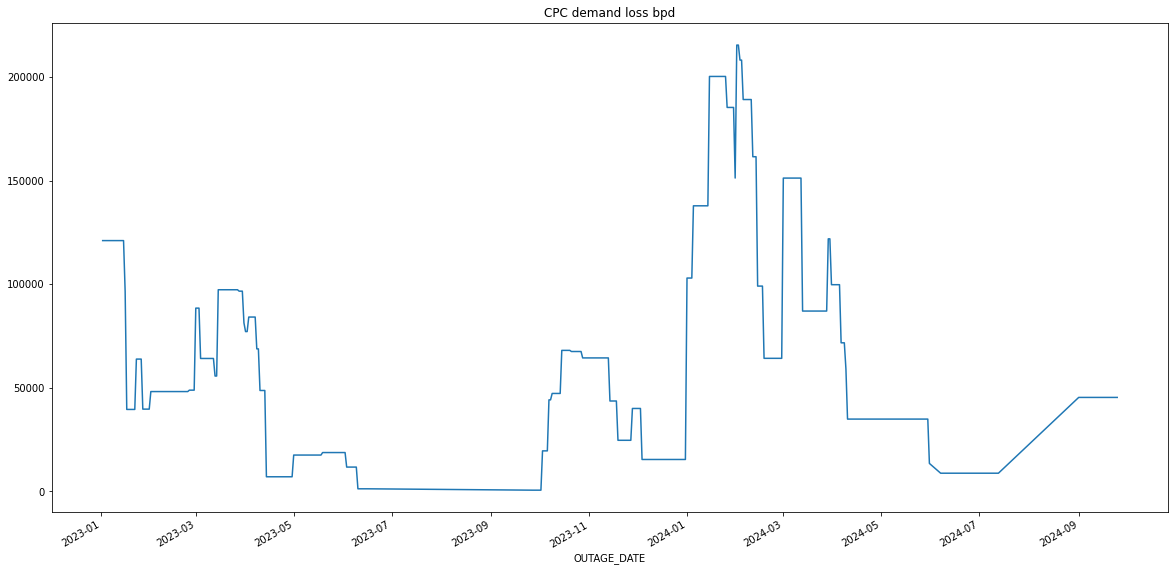

In [70]:
# output_grade('CPC')

c:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

<AxesSubplot:title={'center':'Clov demand loss bpd'}, xlabel='OUTAGE_DATE'>

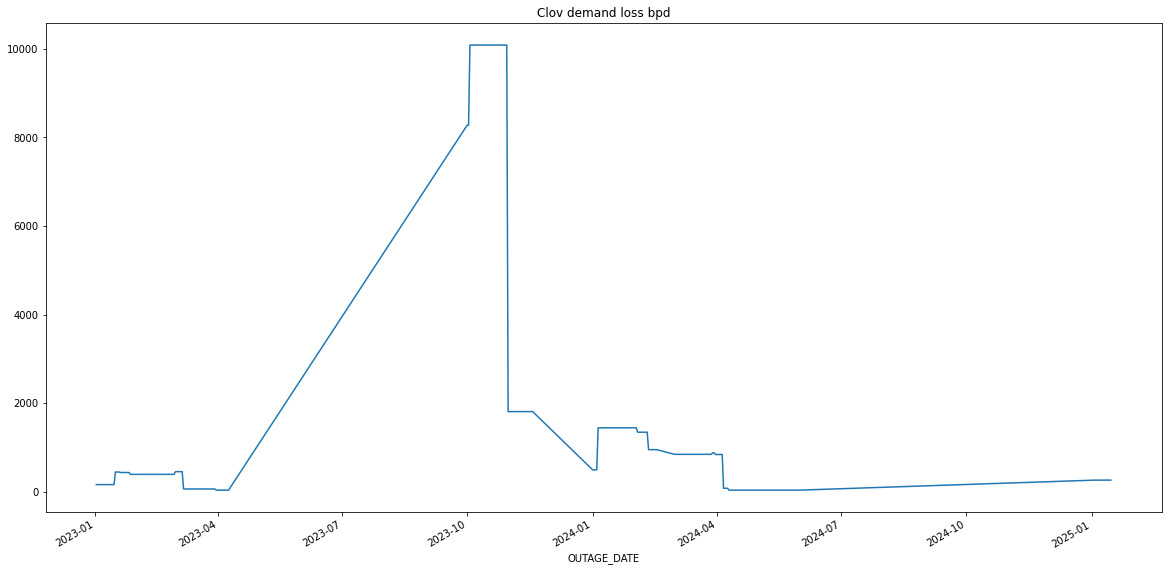

In [26]:
output_grade('Clov')

In [43]:
# cpc_pct = get_grade_pct('CPC')
# cdu_pct = get_cdu_pct()
# to_test = get_scaled_intake('CPC')

In [44]:
# cpc_weighted = get_weighted_outages('CPC')

In [45]:
# cpc_low = get_case(cpc_weighted, 'low')
# cpc_high = get_case(cpc_weighted, 'high')
# cpc_mid = get_case(get_weighted_outages('CPC'), 'mid')

In [ ]:
# cpc_total = get_weighted_outages('CPC').groupby('OUTAGE_DATE')['high','low'].sum()
# cpc_total['average'] = cpc_total.mean(axis=1)
# cpc_total['average'].plot(kind='line', figsize=(20,10), title=f'CPC demand loss bpd')

In [ ]:
# urals_total = get_weighted_outages('Urals').groupby('OUTAGE_DATE')['high','low'].sum()
# urals_total['average'] = urals_total.mean(axis=1)
# urals_total['average'].plot(kind='line', figsize=(20,10), title=f'Urals demand loss bpd')

C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\conda\envs\lng\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

<AxesSubplot:title={'center':'Urals demand loss bpd'}, xlabel='OUTAGE_DATE'>

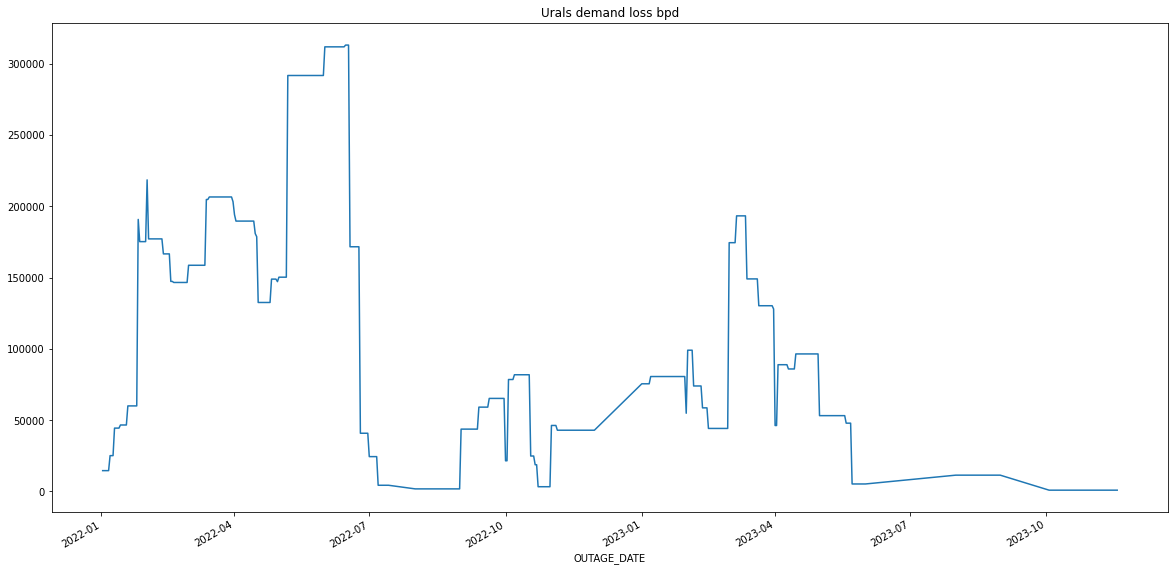

In [22]:
output_grade('Urals')

In [ ]:
cpc_weighted[cpc_weighted['PLANT_NAME']=='PetroIneos Lavera Refinery']

In [ ]:
# cpc_scaler = cpc_refineries_scaled.groupby(['id']).sum(['grade_pct','grade_factor']).drop(columns=['capacity','cdu_pct'])
# cpc_scaler.rename(columns={'CPC':'high_pct', 'cpc_factor':'low_pct'}, inplace=True)
# cpc_scaler.reset_index(inplace=True)
# cpc_scaler.drop(columns='iir_name', inplace=True)

In [ ]:
# cpc_refineries_scaled = cpc.merge(port_mapping_pct,how='inner', on='destination_location_name')
# cpc_refineries_scaled['cpc_factor']  = cpc_refineries_scaled['CPC']*cpc_refineries_scaled['cdu_pct']

In [ ]:
# port_mapping_sc = port_mapping.merge(cdu_capacity, on='id')
# port_mapping_scaled = port_mapping_sc.groupby(['destination_location_name','id']).sum('capacity')
# port_cdu_pct = port_mapping_scaled.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
# port_cdu_pct.rename(columns={'capacity':'cdu_pct'}, inplace=True)

In [17]:
urals_ports = get_grade_pct('Urals')

In [28]:
urals_refineries = get_scaled_intake('Urals')
cpc_refineries = get_scaled_intake('CPC')
sib_refineries = get_scaled_intake('SBL')

In [57]:
total_cdu_query = '''
select  country, plant_name, CAST(plant_id as int) id, sum(U_CAPACITY) cdu from oil.Refinery.RefineryUnit
GROUP BY country, plant_name, plant_id
'''

In [58]:
plant_names = ag_get_data(total_cdu_query)

In [70]:
urals_refs = urals_refineries.merge(plant_names, how='left', on='id')
urals_refs['mid_pct'] = urals_refs[['high_pct', 'low_pct']].mean(axis=1)
urals_refs['bbls'] = urals_refs['cdu']*urals_refs['mid_pct']
urals_refs['bbls'] = urals_refs['bbls'].round(0)

In [71]:
urals_refs

id  high_pct   low_pct         country  \
0   1025052  0.116487  0.116487           Italy   
1   1028251  0.016273  0.016273           Italy   
2   1035138  0.230070  0.230070          Turkey   
3   1036696  0.160067  0.073855          France   
4   1038184  0.022510  0.010331          France   
5   1038441  0.049052  0.049052          France   
6   1043443  0.195949  0.046261         Germany   
7   1046444  0.746350  0.746350       Lithuania   
8   1047074  0.723750  0.128115     Netherlands   
9   1052805  0.113903  0.113903          Greece   
10  1052980  0.280172  0.118216          Greece   
11  1053267  0.592397  0.400268         Romania   
12  1055093  0.028476  0.028476          Israel   
13  1056889  0.160067  0.086212          France   
14  1057762  0.723750  0.268304     Netherlands   
15  1058210  0.642769  0.642769         Belgium   
16  1059023  0.008761  0.008761           Spain   
17  1059058  0.008244  0.008244         Croatia   
18  1060025  0.638622  0.638622        Bulgaria   
19  1061929  0.034766  0.034766          Greece   
20  1063299  1.749127  1.749127         Finland   
21  1065614  1.723750  1.059027     Netherlands   
22  1065969  0.114590  0.114590           Spain   
23  1065976  0.044313  0.044313           Spain   
24  1066611  0.822517  0.367071     Netherlands   
25  1070703  0.138214  0.138214          Sweden   
26  1071375  0.022510  0.005545          France   
27  1071408  0.821090  0.821090          Poland   
28  1071411  0.022510  0.006635          France   
29  1071937  0.196842  0.196842          Turkey   
30  1077363  0.047133  0.017031         Germany   
31  1077429  0.588180  0.588180         Romania   
32  1077610  0.047133  0.005884         Germany   
33  1077813  0.047133  0.003744         Germany   
34  1081063  0.195949  0.030731         Germany   
35  1081337  0.195949  0.033044         Germany   
36  1081615  0.195949  0.046261         Germany   
37  1083069  0.047133  0.004600         Germany   
38  1083108  0.047133  0.006419         Germany   
39  1083161  0.195949  0.039652         Germany   
40  1083209  0.207136  0.207136          Turkey   
41  1083377  0.064101  0.064101           Italy   
42  1083829  0.099564  0.099564           Italy   
43  1083878  0.171788  0.171788           Italy   
44  1083949  0.246192  0.246192           Italy   
45  1084804  0.047133  0.005819  Czech Republic   
46  1084830  0.047133  0.003637  Czech Republic   
47  1085114  0.064260  0.064260          Israel   
48  1087288  0.592397  0.192129         Romania   
49  1087350  0.280172  0.161956          Greece   
50  1087398  1.000000  1.000000         Finland   
51  1089480  0.136200  0.136200          Turkey   

                                 plant_name       cdu   mid_pct       bbls  
0                       Api Ancona Refinery  294200.0  0.116487    34270.0  
1                            Saras Refinery  856700.0  0.016273    13941.0  
2                            Izmir Refinery  484440.0  0.230070   111455.0  
3           Gonfreville Refinery (Normandy)  547575.0  0.116961    64045.0  
4                PetroIneos Lavera Refinery  437300.0  0.016421     7181.0  
5                           Donges Refinery  433500.0  0.049052    21264.0  
6           Gelsenkirchen Scholven Refinery  342500.0  0.121105    41479.0  
7                        Mazeikiai Refinery  664700.0  0.746350   496099.0  
8                        Rotterdam Refinery  502200.0  0.425933   213903.0  
9                     Thessaloniki Refinery  161300.0  0.113903    18373.0  
10                 Athens Elefsina Refinery  265900.0  0.199194    52966.0  
11                      Petrobrazi Refinery  270460.0  0.496332   134238.0  
12                          Ashdod Refinery  362700.0  0.028476    10328.0  
13          Port-Jerome Gravenchon Refinery  544274.0  0.123140    67022.0  
14                    BP Rotterdam Refinery  792000.0  0.496027   392853.0  
15  GPA (Gunvor Petroleum Antwerp) Refinery  286400.0  0.642769   184089.

In [43]:
len(urals_refineries)

52

In [52]:
woodmac_urals = pd.read_excel("urals with id.xlsx", sheet_name='urals')

In [55]:
combined_urals = woodmac_urals.merge(urals_refs,how='outer', on='id')

In [56]:
combined_urals

Country                       Refinery         id  \
0                  Austria                      Schwechat  1036512.0   
1                  Belgium                        Antwerp  1058210.0   
2                  Belgium           Antwerp (ExxonMobil)  1047092.0   
3                  Belgium   Total Raffinaderij Antwerpen  1065738.0   
4   Bosnia and Herzegovina                  Bosanski Brod  1087893.0   
5                 Bulgaria               Neftochim Burgas  1060025.0   
6                  Croatia                         Rijeka  1059058.0   
7           Czech Republic                       Litvinov  1084804.0   
8                  Denmark                     Kalundborg  1034622.0   
9                  Finland                       Naantali  1087398.0   
10                 Finland                         Porvoo  1063299.0   
11                  France                         Donges  1038441.0   
12                  France                    Fos sur Mer  1071411.0   
13                  France           Gonfreville l'Orcher  1036696.0   
14                  France                     Grandpuits  1071380.0   
15                  France                         Lavera  1038184.0   
16                  France         Port-Jerome Gravenchon  1056889.0   
17                 Germany                      Bayernoil        NaN   
18                   Spain                    Somorrostro        NaN   
19                 Germany                  Gelsenkirchen  1043443.0   
20                 Germany                          Heide  1078118.0   
21                 Germany                 Karlsruhe MiRO  1077363.0   
22                 Germany                  Leuna (Mider)  1075709.0   
23                 Germany             Rhineland Refinery  1019998.0   
24                 Germany                        Schwedt  1077614.0   
25                  Greece                    Aspropyrgos  1087350.0   
26                  Greece                        Corinth  1061929.0   
27                  Greece                        Elefsis  1052980.0   
28                  Greece                   Thessaloniki  1052805.0   
29                 Hungary                           Duna  1034725.0   
30                   Italy                        Augusta  1083377.0   
31                   Italy                      Falconara  1025052.0   
32                   Italy                  ISAB (Priolo)  1028184.0   
33                   Italy                        Milazzo  1083878.0   
34                   Italy                     Sannazzaro  1083333.0   
35                   Italy                  Sarroch Saras  1028251.0   
36                   Italy                        Taranto  1084370.0   
37               Lithuania                  Orlen Lietuva  1046444.0   
38             Netherlands      BP Raffinaderij Rotterdam  1057762.0   
39             Netherlands  Gunvor Petroleum Rotterdam BV  1065614.0   
40             Netherlands                         Pernis  1066611.0   
41             Netherlands               Rotterdam (Esso)  1047074.0   
42             Netherlands               Zeeland Refinery  1057919.0   
43                  Norway                         Slagen  1066649.0   
44                  Poland                         Gdansk  1071408.0   
45                  Poland                          Plock  1071307.0   
46                Portugal                          Sines  1076124.0   
47                 Romania                     Petromidia  1077429.0   
48                 Romania                       Petrotel  1087288.0   
49                  Serbia                        Pancevo  1060642.0   
50                Slovakia                     Bratislava  1030789.0   
51                   Spain             Cartagena (Repsol)  1065976.0   
52                   Spain                    Puertollano  1065879.0   
53                   Spain             Tarragona (Repsol)  1065865.0   
54                  Sweden              Preemraff Lysekil  